# Function defs EXPERT

Esta tabla contiene la información de las definiciones de funciones.

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *
from domains import *

TARGET_FEATURE = 'functiondef__expertise_level'
TARGET_CLASS = 'PROFESSIONAL'
full_table = get_data('functiondefs')

instances_for_class_low = len(full_table[full_table[TARGET_FEATURE] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TARGET_FEATURE] == "PROFESSIONAL"])

print(f"The dataset contains {instances_for_class_low} ({instances_for_class_low/len(full_table)*100:.4}%) instances for BEGINNER class and {instances_for_class_high} ({instances_for_class_high/len(full_table)*100:.4}%) for PROFESSIONAL class.")

2025-01-28 11:10:05.171096 Data cache files found ...
2025-01-28 11:10:05.187746 Data cache files successfully loaded!!
The dataset contains 9920 (62.56%) instances for BEGINNER class and 5937 (37.44%) for PROFESSIONAL class.


In [2]:
full_table = full_table[full_table[TARGET_FEATURE] == TARGET_CLASS]

# Table name, features and target.
TABLE_NAME = 'functiondefs'
TABLE_FEATURES = ['functiondef__name_convention', 'functiondef__number_of_characters', 'functiondef__is_magic', 'functiondef__is_private', 'functiondef__body_count', 'functiondef__expressions_pct', 'functiondef__is_async', 'functiondef__number_of_decorators', 'functiondef__has_return_type_annotation', 'functiondef__has_doc_string', 'functiondef__height', 'functiondef__type_annotations_pct']

# Load features and target.
X = full_table[TABLE_FEATURES]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

Features shape: (5937, 12)
As we can see the downloaded data contains a total of 5937 instances. For each instance we have 12 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [3]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5937 entries, 1 to 5955
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   functiondef__name_convention             5937 non-null   object 
 1   functiondef__number_of_characters        5937 non-null   int64  
 2   functiondef__is_magic                    5937 non-null   bool   
 3   functiondef__is_private                  5937 non-null   bool   
 4   functiondef__body_count                  5937 non-null   int64  
 5   functiondef__expressions_pct             5937 non-null   float64
 6   functiondef__is_async                    5937 non-null   bool   
 7   functiondef__number_of_decorators        5937 non-null   int64  
 8   functiondef__has_return_type_annotation  5937 non-null   bool   
 9   functiondef__has_doc_string              5937 non-null   bool   
 10  functiondef__height                      5937 non-nul

Cómo podemos ver la tabla está compuesta por 6 variables numéricas, 5 variables boleanas y dos de tipo objeto. 

### 2.1 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [4]:
X.isnull().sum()

functiondef__name_convention               0
functiondef__number_of_characters          0
functiondef__is_magic                      0
functiondef__is_private                    0
functiondef__body_count                    0
functiondef__expressions_pct               0
functiondef__is_async                      0
functiondef__number_of_decorators          0
functiondef__has_return_type_annotation    0
functiondef__has_doc_string                0
functiondef__height                        0
functiondef__type_annotations_pct          0
dtype: int64

In [5]:
print_empty_cols(X)

functiondef__name_convention
----------------------------
0 instancias no tienen un valor para la columna functiondef__name_convention


functiondef__number_of_characters
---------------------------------
0 instancias no tienen un valor para la columna functiondef__number_of_characters


functiondef__is_magic
---------------------
0 instancias no tienen un valor para la columna functiondef__is_magic


functiondef__is_private
-----------------------
0 instancias no tienen un valor para la columna functiondef__is_private


functiondef__body_count
-----------------------
0 instancias no tienen un valor para la columna functiondef__body_count


functiondef__expressions_pct
----------------------------
0 instancias no tienen un valor para la columna functiondef__expressions_pct


functiondef__is_async
---------------------
0 instancias no tienen un valor para la columna functiondef__is_async


functiondef__number_of_decorators
---------------------------------
0 instancias no tienen un valo

### 2.2 - Describimos los valores de las variables de la tabla.

In [6]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
functiondef__name_convention,5937,5,SnakeCase,5504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__number_of_characters,5937.0,NaN,NaN,NaN,19.301162,9.654733,2.0,12.0,18.0,24.0,87.0
functiondef__is_magic,5937,1,False,5937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__is_private,5937,2,False,5261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__body_count,5937.0,NaN,NaN,NaN,4.852282,4.813388,1.0,2.0,3.0,6.0,51.0
functiondef__expressions_pct,5937.0,NaN,NaN,NaN,0.149237,0.215621,0.0,0.0,0.0,0.25,1.0
functiondef__is_async,5937,2,False,5574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__number_of_decorators,5937.0,NaN,NaN,NaN,0.266128,0.69017,0.0,0.0,0.0,0.0,10.0
functiondef__has_return_type_annotation,5937,2,True,3782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
functiondef__has_doc_string,5937,2,False,3919,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesario ver la distribucion de lo valores para hacer los bins (categorias).

In [7]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "functiondef__expressions_pct": [(0.0, 0.0), (0.0, 0.5), (0.5, 1.0), (1.0, inf)], # min: 0 ; max: 1
    "functiondef__number_of_decorators": [(0.0, 0.0), (0.0, inf)], # min: 0 ; max: 46
    "functiondef__type_annotations_pct": [(0.0, 0.0), (0.0, 1.0), (1.0, inf)], # min: 0 ; max: 1
    "functiondef__number_of_characters": [(1.0, 8.0), (8.0, 12), (12, 18), (18, inf)], # min: 1 ; max: 87
    "functiondef__body_count": [(1.0, 1.0), (1.0, 3.0), (3.0, 5.0), (5.0, inf)], # min: 1 ; max: 364
    "functiondef__height": [(1.0, 1.0), (1.0, 1.9), (2.0, 2.0), (2.0, inf)], # min: 1 ; max: 10
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['functiondef__expressions_pct'], 10))
print(get_statistics(X_copy, ['functiondef__number_of_decorators'], 10))
print(get_statistics(X_copy, ['functiondef__type_annotations_pct'], 10))
print(get_statistics(X_copy, ['functiondef__number_of_characters'], 10))
print(get_statistics(X_copy, ['functiondef__body_count'], 10))
print(get_statistics(X_copy, ['functiondef__height'], 10))
print(get_statistics(X_copy, ['functiondef__name_convention'], 10))
print(get_statistics(X_copy, ['functiondef__is_private'], 10))
print(get_statistics(X_copy, ['functiondef__is_magic'], 10))
print(get_statistics(X_copy, ['functiondef__is_async'], 10))
print(get_statistics(X_copy, ['functiondef__has_return_type_annotation'], 10))
print(get_statistics(X_copy, ['functiondef__has_doc_string'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['functiondef__number_of_characters', 'functiondef__name_convention_SnakeCase'], 10))
#print(get_statistics(X_copy, ['functiondef__number_of_characters', 'functiondef__name_convention_Lower'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
functiondef__expressions_pct  count  percentage
                   [0.0_0.0]   3158   53.191848
                   [0.0_0.5)   2047   34.478693
                   [0.5_1.0)    614   10.341924
                   [1.0_inf]    118    1.987536

functiondef__number_of_decorators  count  percentage
                        [0.0_0.0]   4826   81.286845
                        [0.0_inf]   1111   18.713155

functiondef__type_annotations_pct  count  percentage
                        [1.0_inf]   3811   64.190669
                        [0.0_0.0]   2001   33.703891
                        [0.0_1.0)    125    2.105440

functiondef__number_of_characters  count  percentage
                         [18_inf]   3200   53.899276
                          [12_18)   1414   23.816742
                         [8.0_12)    911   15.344450
                        [1.0_8.0)    412    6.939532

functiondef__body_count  count  percentage
              [5.0_inf]   2153   36.264106
           

In [8]:
def normalize_datatypes(X:pd.DataFrame) -> (pd.DataFrame, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')        
    columns_names = X.columns.tolist()
    return X, columns_names

X, TABLE_FEATURES = normalize_datatypes(X)
# Print information about the loaded table
print(f'Features shape: {X.shape}')

Features shape: (5937, 16)


#### Muestra la matriz de correlación de Spearman entre las variables de la tabla.

<Axes: >

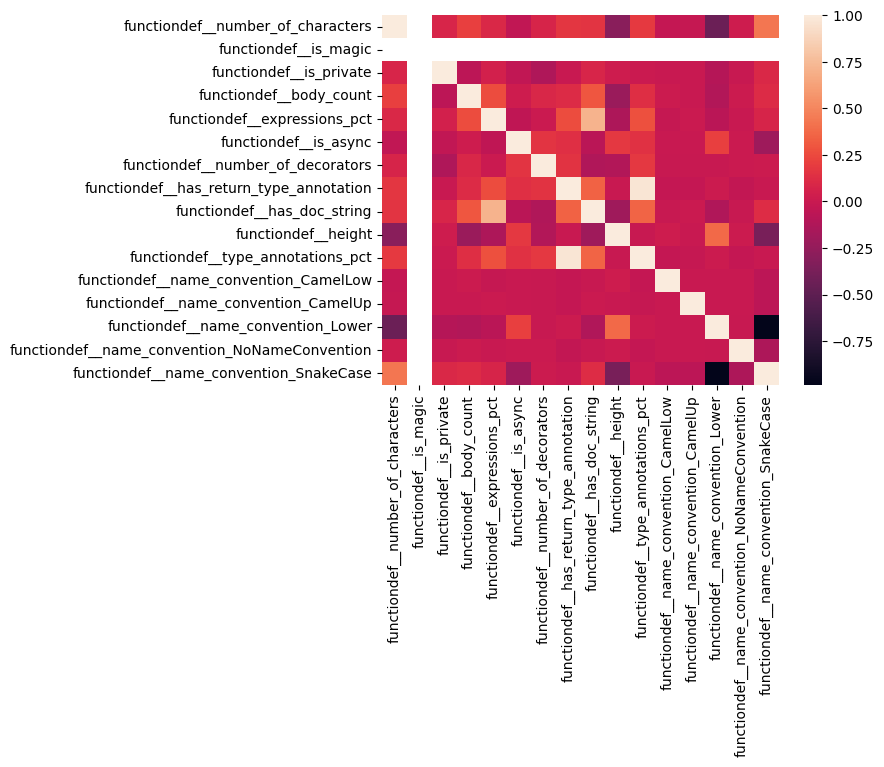

In [9]:
sns.heatmap(X.corr(method='spearman'), annot=False)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 12 variables (2 porcentuales, 4 numericas, 5 booleanas y 1 categorica)

### Variable is_private (1/12)
Esta variable es de tipo booleano y representa si la función es privada.

<Axes: xlabel='functiondef__is_private', ylabel='Count'>

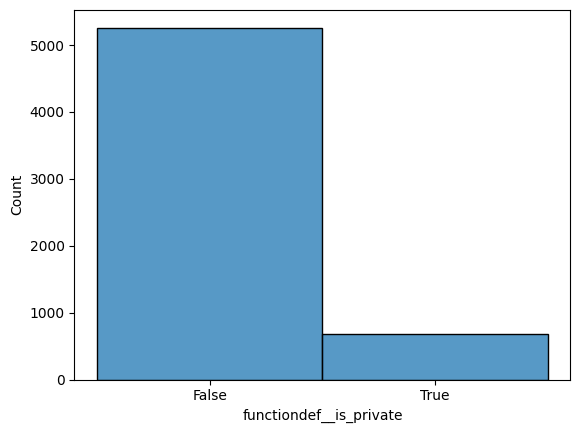

In [10]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_private'], discrete=True)

In [11]:
num_true_values = len(X[X['functiondef__is_private'] == True])
num_false_values = len(X[X['functiondef__is_private'] == False])
std = X['functiondef__is_private'].std()
freq_true = len(X[X['functiondef__is_private'] == True]) / len(X['functiondef__is_private'])
freq_false = len(X[X['functiondef__is_private'] == False]) / len(X['functiondef__is_private'])
print(f'La variable is_private contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_private a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_private a False es {freq_false}.')

La variable is_private contiene 676 valores verdaderos y 5261 valores falsos. Y, la desviación típica es de 0.317670613527298
La frecuencia con la que programa puede tener la variable is_private a True es 0.11386221997641907.
La frecuencia con la que programa puede tener la variable is_private a False es 0.8861377800235809.


In [12]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_private', possible_values)

La variable functiondef__is_private contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_private toma el valor de 0.0 en un 88.61% de los items.
La variable functiondef__is_private toma el valor de 1.0 en un 11.39% de los items.


In [13]:
X[X['functiondef__is_private'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,676.000000,676.0,676.0,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.0,676.0,676.0,676.0,676.0
mean,20.647928,0.0,1.0,4.068048,0.173179,0.034024,0.062130,0.634615,0.448225,1.239645,0.660234,0.0,0.0,0.0,0.0,1.0
std,7.402923,0.0,0.0,4.071012,0.205713,0.181424,0.296624,0.481894,0.497680,0.645414,0.464671,0.0,0.0,0.0,0.0,0.0
min,3.000000,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,1.0
25%,16.000000,0.0,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,1.0
50%,20.000000,0.0,1.0,3.000000,0.087121,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0
75%,25.000000,0.0,1.0,5.000000,0.333333,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0
max,47.000000,0.0,1.0,35.000000,1.000000,1.000000,3.000000,1.000000,1.000000,5.000000,1.000000,0.0,0.0,0.0,0.0,1.0


### Variable is_magic (2/12)
Esta variable es de tipo booleano y representa si la función es de la forma __\w__.

<Axes: xlabel='functiondef__is_magic', ylabel='Count'>

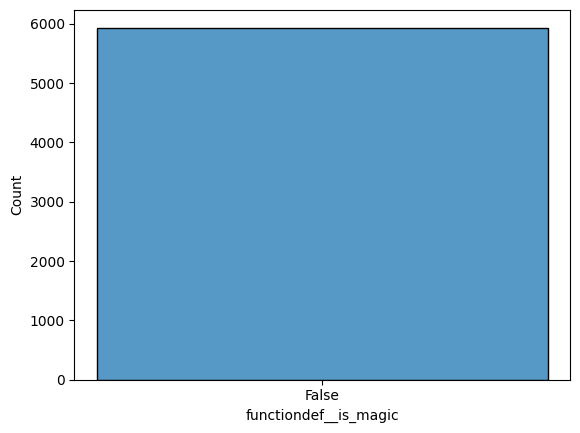

In [14]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_magic'], discrete=True)

In [15]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__is_magic'] == True])
num_false_values = len(X[X['functiondef__is_magic'] == False])
std = X['functiondef__is_magic'].std()
freq_true = len(X[X['functiondef__is_magic'] == True]) / len(X['functiondef__is_magic'])
freq_false = len(X[X['functiondef__is_magic'] == False]) / len(X['functiondef__is_magic'])
print(f'La variable is_magic contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_magic a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_magic a False es {freq_false}.')

La variable is_magic contiene 0 valores verdaderos y 5937 valores falsos. Y, la desviación típica es de 0.0
La frecuencia con la que programa puede tener la variable is_magic a True es 0.0.
La frecuencia con la que programa puede tener la variable is_magic a False es 1.0.


In [16]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_magic', possible_values)

La variable functiondef__is_magic contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_magic toma el valor de 0.0 en un 100.0% de los items.
La variable functiondef__is_magic toma el valor de True en un 0.0% de los items. [OUTLIER]


In [17]:
X[X['functiondef__is_magic'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Variable is_async (3/12)
Esta variable es booleana y representa si la función es asincrona.

<Axes: xlabel='functiondef__is_async', ylabel='Count'>

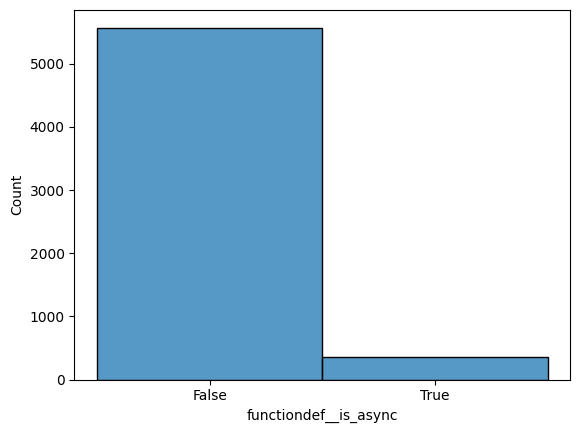

In [18]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__is_async'], discrete=True)

In [19]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__is_async'] == True])
num_false_values = len(X[X['functiondef__is_async'] == False])
std = X['functiondef__is_async'].std()
freq_true = len(X[X['functiondef__is_async'] == True]) / len(X['functiondef__is_async'])
freq_false = len(X[X['functiondef__is_async'] == False]) / len(X['functiondef__is_async'])
print(f'La variable is_async contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable is_async a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable is_async a False es {freq_false}.')

La variable is_async contiene 363 valores verdaderos y 5574 valores falsos. Y, la desviación típica es de 0.23961076140403748
La frecuencia con la que programa puede tener la variable is_async a True es 0.06114199090449722.
La frecuencia con la que programa puede tener la variable is_async a False es 0.9388580090955028.


In [20]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__is_async', possible_values)

La variable functiondef__is_async contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__is_async toma el valor de 0.0 en un 93.89% de los items.
La variable functiondef__is_async toma el valor de 1.0 en un 6.114% de los items.


In [21]:
X[X['functiondef__is_async'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,363.000000,363.0,363.000000,363.000000,363.000000,363.0,363.000000,363.000000,363.000000,363.000000,363.000000,363.0,363.0,363.000000,363.000000,363.000000
mean,18.030304,0.0,0.063361,5.275482,0.105829,1.0,0.848485,0.895317,0.203857,1.661157,0.912305,0.0,0.0,0.275482,0.002755,0.721763
std,12.634980,0.0,0.243947,4.908683,0.169894,0.0,1.199294,0.306567,0.403420,1.060754,0.280929,0.0,0.0,0.447374,0.052486,0.448749
min,3.000000,0.0,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,6.000000,0.0,0.000000,2.000000,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
50%,17.000000,0.0,0.000000,3.000000,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
75%,24.000000,0.0,0.000000,7.500000,0.200000,1.0,2.000000,1.000000,0.000000,2.000000,1.000000,0.0,0.0,1.000000,0.000000,1.000000
max,69.000000,0.0,1.000000,32.000000,1.000000,1.0,5.000000,1.000000,1.000000,6.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000


### Variable has_return_type_annotation (4/12)
Esta variable es booleana y representa si la function tiene una anotacion del tipo de retorno.

<Axes: xlabel='functiondef__has_return_type_annotation', ylabel='Count'>

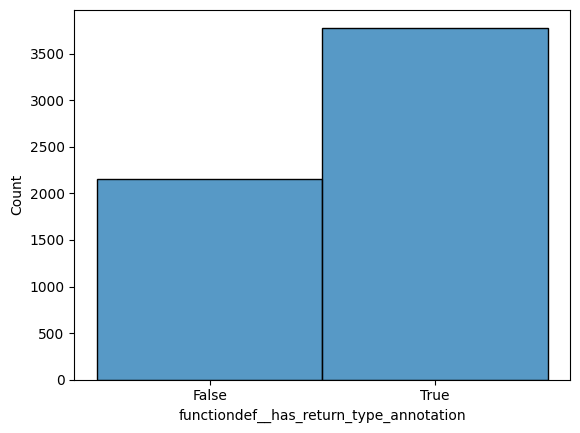

In [22]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__has_return_type_annotation'], discrete=True)

In [23]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__has_return_type_annotation'] == True])
num_false_values = len(X[X['functiondef__has_return_type_annotation'] == False])
std = X['functiondef__has_return_type_annotation'].std()
freq_true = len(X[X['functiondef__has_return_type_annotation'] == True]) / len(X['functiondef__has_return_type_annotation'])
freq_false = len(X[X['functiondef__has_return_type_annotation'] == False]) / len(X['functiondef__has_return_type_annotation'])
print(f'La variable has_return_type_annotation contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_return_type_annotation a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_return_type_annotation a False es {freq_false}.')

La variable has_return_type_annotation contiene 3782 valores verdaderos y 2155 valores falsos. Y, la desviación típica es de 0.48089906573295593
La frecuencia con la que programa puede tener la variable has_return_type_annotation a True es 0.6370220650160013.
La frecuencia con la que programa puede tener la variable has_return_type_annotation a False es 0.36297793498399866.


In [24]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__has_return_type_annotation', possible_values)

La variable functiondef__has_return_type_annotation contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__has_return_type_annotation toma el valor de 1.0 en un 63.7% de los items.
La variable functiondef__has_return_type_annotation toma el valor de 0.0 en un 36.3% de los items.


In [25]:
X[X['functiondef__has_return_type_annotation'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,3782.000000,3782.0,3782.000000,3782.000000,3782.000000,3782.000000,3782.000000,3782.0,3782.000000,3782.000000,3782.000000,3782.0,3782.0,3782.000000,3782.000000,3782.000000
mean,20.445004,0.0,0.113432,5.099947,0.180282,0.085933,0.303807,1.0,0.462718,1.216023,0.994892,0.0,0.0,0.073506,0.000529,0.925965
std,10.187791,0.0,0.317162,4.892611,0.218902,0.280303,0.639427,0.0,0.498674,0.641200,0.050895,0.0,0.0,0.261000,0.022993,0.261862
min,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.166667,0.0,0.0,0.000000,0.000000,0.000000
25%,14.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
50%,19.000000,0.0,0.000000,4.000000,0.111111,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
75%,25.000000,0.0,0.000000,6.000000,0.333333,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
max,87.000000,0.0,1.000000,51.000000,1.000000,1.000000,5.000000,1.0,1.000000,6.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000


### Variable has_doc_string (5/12)
Esta variable es booleana y representa si la function comienza por un String plano a modo de comentario.

<Axes: xlabel='functiondef__has_doc_string', ylabel='Count'>

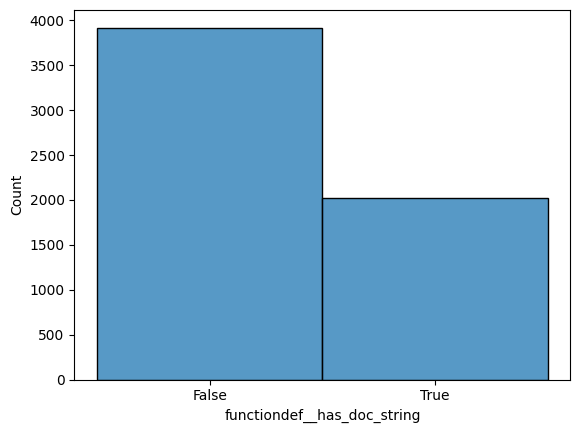

In [26]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['functiondef__has_doc_string'], discrete=True)

In [27]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['functiondef__has_doc_string'] == True])
num_false_values = len(X[X['functiondef__has_doc_string'] == False])
std = X['functiondef__has_doc_string'].std()
freq_true = len(X[X['functiondef__has_doc_string'] == True]) / len(X['functiondef__has_doc_string'])
freq_false = len(X[X['functiondef__has_doc_string'] == False]) / len(X['functiondef__has_doc_string'])
print(f'La variable has_doc_string contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_doc_string a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_doc_string a False es {freq_false}.')

La variable has_doc_string contiene 2018 valores verdaderos y 3919 valores falsos. Y, la desviación típica es de 0.4737156629562378
La frecuencia con la que programa puede tener la variable has_doc_string a True es 0.33990230756274215.
La frecuencia con la que programa puede tener la variable has_doc_string a False es 0.6600976924372579.


In [28]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'functiondef__has_doc_string', possible_values)

La variable functiondef__has_doc_string contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable functiondef__has_doc_string toma el valor de 0.0 en un 66.01% de los items.
La variable functiondef__has_doc_string toma el valor de 1.0 en un 33.99% de los items.


In [29]:
X[X['functiondef__has_doc_string'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,2018.000000,2018.0,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.0,2018.000000,2018.000000,2018.0,2018.000000,2018.000000,2018.000000,2018.000000
mean,21.009911,0.0,0.150149,6.265610,0.301797,0.036670,0.159068,0.867195,1.0,1.051536,0.883224,0.0,0.000496,0.027255,0.000991,0.971259
std,8.409801,0.0,0.357306,5.532418,0.175350,0.187997,0.486781,0.339448,0.0,0.299264,0.315142,0.0,0.022261,0.162865,0.031474,0.167120
min,3.000000,0.0,0.000000,1.000000,0.022222,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.0,0.000000,3.000000,0.166667,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
50%,20.000000,0.0,0.000000,4.000000,0.250000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,26.000000,0.0,0.000000,8.000000,0.500000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,54.000000,0.0,1.000000,51.000000,1.000000,1.000000,5.000000,1.000000,1.0,5.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


### Variable number_of_characters (6/12)
Esta variable representa el número de caracteres que tiene el nombre de la funcion. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 2 - 87. Con una media de 19.3.

<Axes: ylabel='functiondef__number_of_characters'>

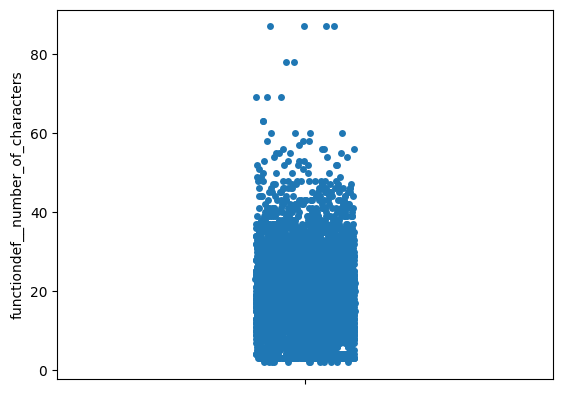

In [30]:
sns.stripplot(X['functiondef__number_of_characters'])

In [31]:
print_outliers_for_df_column(X, 'functiondef__number_of_characters')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.6878031267870579
Rango valores atípicos extremos (Tukey): [-24.0,60.0]
Rango valores atípicos leves (Tukey): [-6.0,42.0]
Rango valores atípicos extremos (Fixed BoxPlot): [10.37897151652993,305.9089834291048]
-3.0IQR: 0 instancias tienen un valor para functiondef__number_of_characters inferior a -24.0 (Q1-3*IQR) para functiondef__number_of_characters. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__number_of_characters inferior a -6.0 (Q1-1.5*IQR) para functiondef__number_of_characters. Representando un 0.0% del total de instancias.
+1.5IQR: 133 instancias tienen un valor para functiondef__number_of_characters superior a 42.0 (Q3+1.5*IQR) para functiondef__number_of_characters. Representando un 2.24% del total de instancias.
+3.0IQR: 11 instancias tienen un valor para functiondef__number_of_characters superior a 60.0 (Q3-3*IQR) para functiondef__number_of_characters. Repres

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 42.0 (Con un MC de 68 usamos Tuckey)

In [54]:
X[X['functiondef__number_of_characters'] > 42].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,133.000000,133.0,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.0,133.000000,133.0,133.0,133.0,133.000000,133.000000
mean,50.255638,0.0,0.030075,5.842105,0.117147,0.142857,0.639098,0.879699,0.278196,1.0,0.899749,0.0,0.0,0.0,0.007519,0.992481
std,9.395078,0.0,0.171440,4.219080,0.165353,0.351250,1.096401,0.326543,0.449804,0.0,0.298664,0.0,0.0,0.0,0.086711,0.086711
min,43.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,44.000000,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,0.0,0.0,0.0,0.000000,1.000000
50%,47.000000,0.0,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,0.0,0.0,0.0,0.000000,1.000000
75%,53.000000,0.0,0.000000,8.000000,0.250000,0.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.0,0.0,0.0,0.000000,1.000000
max,87.000000,0.0,1.000000,25.000000,0.666667,1.000000,5.000000,1.000000,1.000000,1.0,1.000000,0.0,0.0,0.0,1.000000,1.000000


### IMPORTANTE
Hay que revisar los 4 con nombres de mas de 80 caracteres

### Variable body_count (7/12)
Esta variable representa el número de sentencias en el root de la función. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 51. Con una media de 4.85.

<Axes: ylabel='functiondef__body_count'>

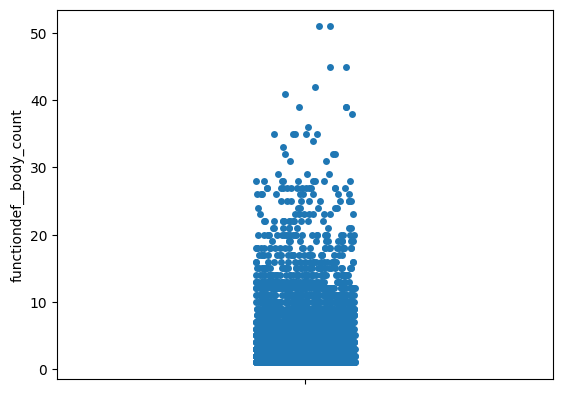

In [33]:
sns.stripplot(X['functiondef__body_count'])

In [34]:
print_outliers_for_df_column(X, 'functiondef__body_count')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8655303232037291
Rango valores atípicos extremos (Tukey): [-10.0,18.0]
Rango valores atípicos leves (Tukey): [-4.0,12.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.7099194575526198,197.30724765195097]
-3.0IQR: 0 instancias tienen un valor para functiondef__body_count inferior a -10.0 (Q1-3*IQR) para functiondef__body_count. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__body_count inferior a -4.0 (Q1-1.5*IQR) para functiondef__body_count. Representando un 0.0% del total de instancias.
+1.5IQR: 367 instancias tienen un valor para functiondef__body_count superior a 12.0 (Q3+1.5*IQR) para functiondef__body_count. Representando un 6.182% del total de instancias.
+3.0IQR: 145 instancias tienen un valor para functiondef__body_count superior a 18.0 (Q3-3*IQR) para functiondef__body_count. Representando un 2.442% del total de instancias.
L: 924 instancias tienen un valor

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 18.0 (Con un MC de 86 usamos Tuckey Extremo)

In [35]:
X[X['functiondef__body_count'] > 18].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,145.000000,145.0,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.0,145.0,145.000000,145.000000,145.000000
mean,20.862068,0.0,0.075862,25.372414,0.136763,0.068966,0.613793,0.648276,0.558621,1.013793,0.693360,0.0,0.0,0.062069,0.006897,0.931035
std,9.441795,0.0,0.265695,6.492458,0.180360,0.254274,1.143740,0.479164,0.498273,0.117036,0.452666,0.0,0.0,0.242117,0.083045,0.254274
min,4.000000,0.0,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,14.000000,0.0,0.000000,20.000000,0.038462,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000
50%,20.000000,0.0,0.000000,24.000000,0.080000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
75%,27.000000,0.0,0.000000,27.000000,0.160000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
max,47.000000,0.0,1.000000,51.000000,0.925926,1.000000,7.000000,1.000000,1.000000,2.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000


### Variable number_of_decorators (8/12)
Esta variable representa el número de decoradores de la funcion. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 10. Con una media de 0.266.

<Axes: ylabel='functiondef__number_of_decorators'>

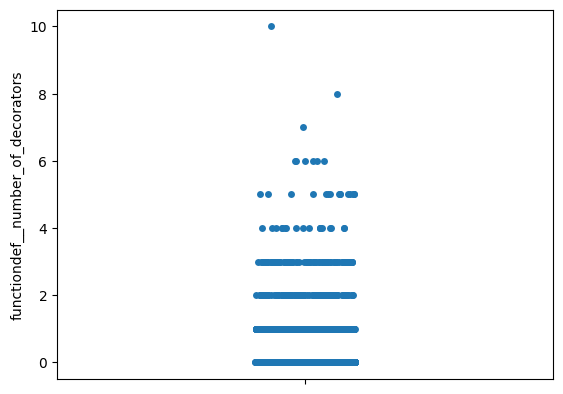

In [36]:
sns.stripplot(X['functiondef__number_of_decorators'])

In [37]:
print_outliers_for_df_column(X, 'functiondef__number_of_decorators')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.7938948394819505
Rango valores atípicos extremos (Tukey): [0.0,0.0]
Rango valores atípicos leves (Tukey): [0.0,0.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.0,0.0]
-3.0IQR: 0 instancias tienen un valor para functiondef__number_of_decorators inferior a 0.0 (Q1-3*IQR) para functiondef__number_of_decorators. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__number_of_decorators inferior a 0.0 (Q1-1.5*IQR) para functiondef__number_of_decorators. Representando un 0.0% del total de instancias.
+1.5IQR: 1111 instancias tienen un valor para functiondef__number_of_decorators superior a 0.0 (Q3+1.5*IQR) para functiondef__number_of_decorators. Representando un 18.71% del total de instancias.
+3.0IQR: 1111 instancias tienen un valor para functiondef__number_of_decorators superior a 0.0 (Q3-3*IQR) para functiondef__number_of_decorators. Representando un 18.71% del total de ins

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0 (Con un MC de 79 usamos Tuckey Extremo)

In [55]:
X[X['functiondef__number_of_decorators'] > 0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,1111.000000,1111.0,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.0,1111.0,1111.000000,1111.000000,1111.000000
mean,20.929792,0.0,0.031503,5.818182,0.152210,0.132313,1.422142,0.789379,0.220522,1.090909,0.823627,0.0,0.0,0.069307,0.001800,0.928893
std,10.650573,0.0,0.174752,5.405642,0.229459,0.338984,0.949640,0.407933,0.414785,0.478189,0.377946,0.0,0.0,0.254090,0.042409,0.257119
min,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,13.000000,0.0,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
50%,19.000000,0.0,0.000000,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
75%,25.000000,0.0,0.000000,8.000000,0.250000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000
max,69.000000,0.0,1.000000,32.000000,1.000000,1.000000,10.000000,1.000000,1.000000,7.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000


### Variable height (9/12)
Esta variable representa la distancia desde la función hasta el root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 7. Con una media de 1.23.

<Axes: ylabel='functiondef__height'>

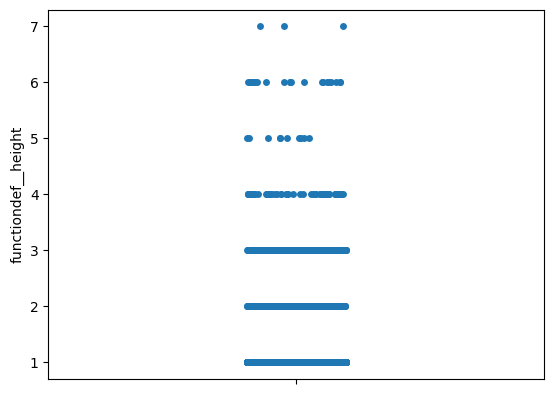

In [39]:
sns.stripplot(X['functiondef__height'])

In [40]:
print_outliers_for_df_column(X, 'functiondef__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 1.0
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 0 instancias tienen un valor para functiondef__height inferior a 1.0 (Q1-3*IQR) para functiondef__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__height inferior a 1.0 (Q1-1.5*IQR) para functiondef__height. Representando un 0.0% del total de instancias.
+1.5IQR: 746 instancias tienen un valor para functiondef__height superior a 1.0 (Q3+1.5*IQR) para functiondef__height. Representando un 12.57% del total de instancias.
+3.0IQR: 746 instancias tienen un valor para functiondef__height superior a 1.0 (Q3-3*IQR) para functiondef__height. Representando un 12.57% del total de instancias.
L: 0 instancias tienen un valor para functiondef__height inferior a 1.0 para functiondef__height. Representando un 0.0% 

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 1.0 (Todos los umbrales son 1)

In [41]:
X[X['functiondef__height'] > 1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,746.000000,746.0,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.0,746.000000,746.000000,746.000000
mean,12.010724,0.0,0.135389,2.702413,0.109356,0.172922,0.072386,0.634048,0.099196,2.817694,0.639768,0.001340,0.0,0.324397,0.002681,0.671582
std,7.529977,0.0,0.342368,2.260230,0.237723,0.378434,0.259300,0.482019,0.299125,0.896830,0.473682,0.036613,0.0,0.468463,0.051743,0.469953
min,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,5.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,11.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.000000
75%,17.000000,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.0,1.000000,0.000000,1.000000
max,36.000000,0.0,1.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


### Variable expressions_pct (10/12)
Esta variable representa la proporción de las sentencias en el root de la funcion que son expresiones. Toma los valores de 0.0 - 1.0. La media es 0.149.

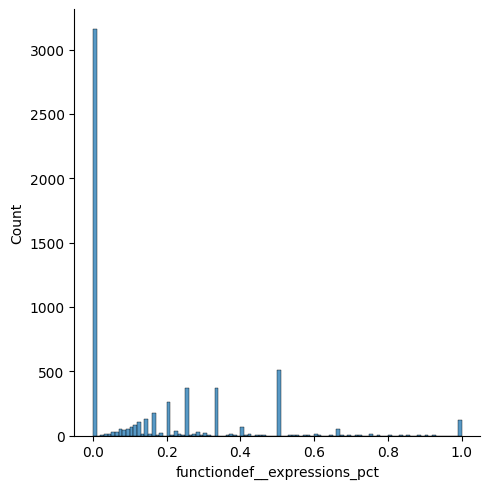

In [42]:
sns.displot(X['functiondef__expressions_pct'], bins=[i / 100 for i in range(0, 101)])

In [43]:
print_outliers_for_df_column(X, 'functiondef__expressions_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.48816289017016345
Rango valores atípicos extremos (Tukey): [-0.75,1.0]
Rango valores atípicos leves (Tukey): [-0.375,0.625]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.06792172304166433,2.8927559884843426]
-3.0IQR: 0 instancias tienen un valor para functiondef__expressions_pct inferior a -0.75 (Q1-3*IQR) para functiondef__expressions_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__expressions_pct inferior a -0.375 (Q1-1.5*IQR) para functiondef__expressions_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 201 instancias tienen un valor para functiondef__expressions_pct superior a 0.625 (Q3+1.5*IQR) para functiondef__expressions_pct. Representando un 3.386% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para functiondef__expressions_pct superior a 1.0 (Q3-3*IQR) para functiondef__expressions_pct. Representando un 0.0% del total de in

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0.625 (Con un MC de 0.48 usamos Tuckey)

In [56]:
X[X['functiondef__expressions_pct'] > 0.625].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,201.000000,201.0,201.000000,201.00000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.0,201.0,201.000000,201.0,201.000000
mean,16.378109,0.0,0.034826,4.20398,0.878131,0.019900,0.427861,0.661692,0.373134,1.313433,0.681592,0.0,0.0,0.084577,0.0,0.915423
std,8.436605,0.0,0.183796,5.16364,0.151957,0.140007,0.834278,0.474315,0.484845,0.925348,0.467022,0.0,0.0,0.278946,0.0,0.278946
min,2.000000,0.0,0.000000,1.00000,0.642857,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
25%,10.000000,0.0,0.000000,1.00000,0.666667,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
50%,15.000000,0.0,0.000000,3.00000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0.0,1.000000
75%,20.000000,0.0,0.000000,4.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.0,1.000000
max,46.000000,0.0,1.000000,28.00000,1.000000,1.000000,5.000000,1.000000,1.000000,7.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000


### Variable type_annotations_pct (11/12)
Esta variable representa la proporción de los parámetros que tienen anotación de tipo en la función (incluyendo el return). Este campo toma valores del 0.0 - 1.0. Su media es 0.31.

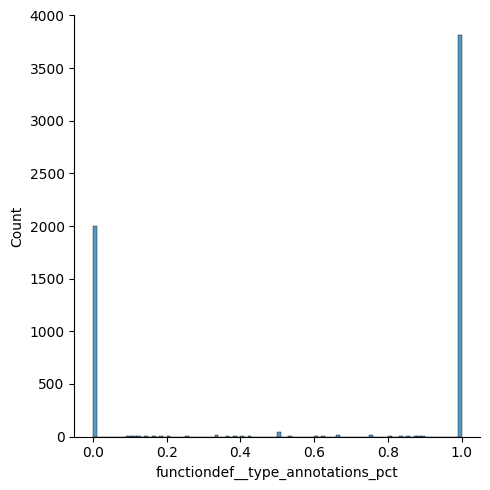

In [45]:
sns.displot(X['functiondef__type_annotations_pct'], bins=[i / 100 for i in range(0, 101)])

In [46]:
print_outliers_for_df_column(X, 'functiondef__type_annotations_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: -0.3435008931678355
Rango valores atípicos extremos (Tukey): [-3.0,4.0]
Rango valores atípicos leves (Tukey): [-1.5,2.5]
Rango valores atípicos extremos (Fixed BoxPlot): [-5.926706608752534,1.4507745209798937]
-3.0IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct inferior a -3.0 (Q1-3*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct inferior a -1.5 (Q1-1.5*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct superior a 2.5 (Q3+1.5*IQR) para functiondef__type_annotations_pct. Representando un 0.0% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para functiondef__type_annotations_pct superior a 4.0 (Q3-3*IQR) para functiondef__type_annotations_pct. Representando

IMPORTANTE: Estos valores siguen un distribucion en forma de U (distribucion de Laplace). Con lo que los posibles valores outliers estan en el medio, no en los extremos. No se puede aplicar el metodo de tukey. En este momento, solo vamos a mostrar los valores que hay en el medio.

In [47]:
X[(X['functiondef__type_annotations_pct'] > 0.0) & (X['functiondef__type_annotations_pct'] < 1.0)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,functiondef__number_of_characters,functiondef__is_magic,functiondef__is_private,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__name_convention_CamelLow,functiondef__name_convention_CamelUp,functiondef__name_convention_Lower,functiondef__name_convention_NoNameConvention,functiondef__name_convention_SnakeCase
count,3936.000000,3936.0,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.0,3936.000000,3936.000000,3936.000000,3936.000000
mean,20.447662,0.0,0.116362,5.171748,0.179005,0.084350,0.320630,0.960874,0.457063,1.213161,0.984937,0.0,0.000254,0.071900,0.001270,0.926575
std,10.121061,0.0,0.320699,4.968667,0.218521,0.277947,0.681087,0.193919,0.498216,0.636093,0.090412,0.0,0.015939,0.258356,0.035624,0.260866
min,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.090909,0.0,0.000000,0.000000,0.000000,0.000000
25%,14.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
50%,19.000000,0.0,0.000000,4.000000,0.111111,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,25.000000,0.0,0.000000,7.000000,0.307692,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,87.000000,0.0,1.000000,51.000000,1.000000,1.000000,5.000000,1.000000,1.000000,6.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


### Variable name_convention (12/12)
Esta variable es de tipo categórica y representa la name_convention del nombre de la funcion.

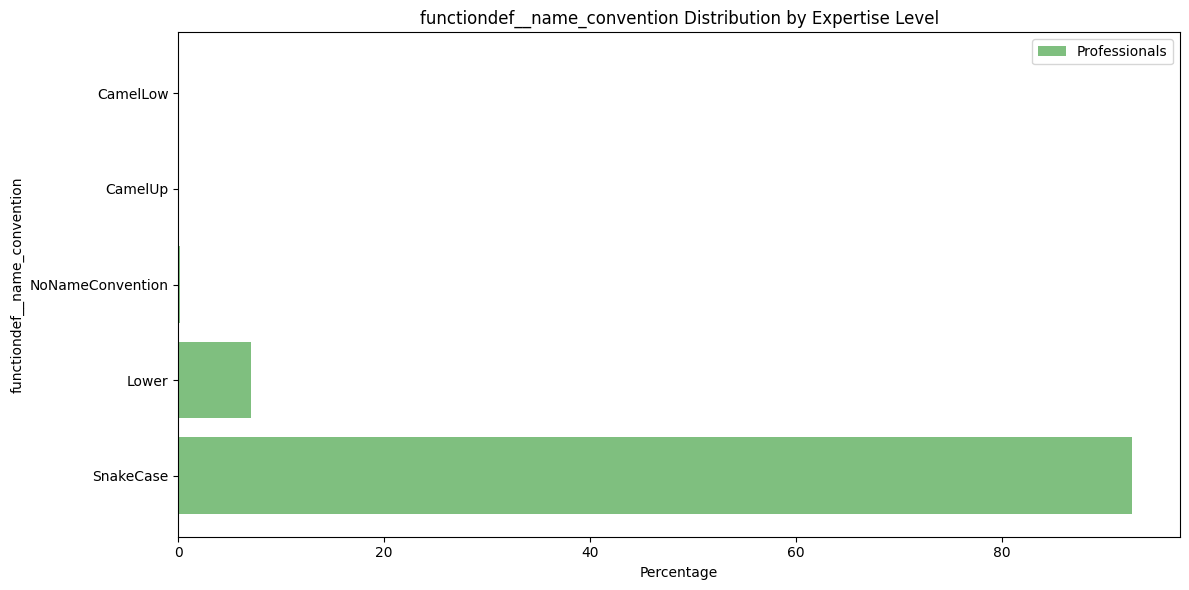

In [48]:
print_categorical_histogram(full_table, 'functiondef__name_convention',TARGET_FEATURE, include_all=False, include_beginners=False)

In [49]:
print_frequency_anal_for_cat_var(full_table, 'functiondef__name_convention')

La variable functiondef__name_convention contiene 5 valores distintos.
El umbral de outlier es de 0.04%
La variable functiondef__name_convention toma el valor de SnakeCase en un 92.71% de los items.
La variable functiondef__name_convention toma el valor de Lower en un 7.074% de los items.
La variable functiondef__name_convention toma el valor de NoNameConvention en un 0.1516% de los items.
La variable functiondef__name_convention toma el valor de CamelUp en un 0.03369% de los items. [OUTLIER]
La variable functiondef__name_convention toma el valor de CamelLow en un 0.03369% de los items. [OUTLIER]


In [50]:
print_values_usage_for_cat_var(full_table, 'functiondef__name_convention', NAMING_CONVENTION_VALUES)

La variable functiondef__name_convention puede tomar 7 valores distintos
	5 (71.43%) valores utilizados
	2 (28.57%) valores NO utilizados
		La variable functiondef__name_convention nunca toma valor Discard.
		La variable functiondef__name_convention nunca toma valor Upper.


## Multivariate

Isolation forest algorithm

In [51]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,functiondef_id,functiondef__name_convention,functiondef__number_of_characters,functiondef__is_private,functiondef__is_magic,functiondef__body_count,functiondef__expressions_pct,functiondef__is_async,functiondef__number_of_decorators,functiondef__has_return_type_annotation,functiondef__has_doc_string,functiondef__height,functiondef__type_annotations_pct,functiondef__expertise_level
613,245125,Lower,5,False,False,21,0.904762,False,0,False,False,1,0.0,PROFESSIONAL
1142,150269,Lower,7,False,False,5,0.400000,False,0,False,False,6,0.0,PROFESSIONAL
1195,140032,Lower,7,False,False,10,0.300000,False,1,False,False,4,0.0,PROFESSIONAL
1202,139939,Lower,7,False,False,3,0.333333,False,1,False,False,5,0.0,PROFESSIONAL
1253,129066,Lower,7,False,False,5,0.400000,False,0,False,False,6,0.0,PROFESSIONAL
1269,111512,Lower,7,False,False,5,0.400000,False,0,False,False,6,0.0,PROFESSIONAL
2095,1017940,SnakeCase,46,False,False,11,0.363636,True,4,False,False,1,1.0,PROFESSIONAL
2099,1017609,SnakeCase,50,False,False,10,0.300000,True,5,False,False,1,1.0,PROFESSIONAL


### IMPORTANTE
Hay que analizar los 38 los outliers de la tabla.

In [52]:
# Outliers
np.transpose(X[mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
functiondef__number_of_characters,8.0,17.000000,19.175879,5.0,7.000,7.000000,16.75,50.000000
functiondef__is_magic,8.0,0.000000,0.000000,0.0,0.000,0.000000,0.00,0.000000
functiondef__is_private,8.0,0.000000,0.000000,0.0,0.000,0.000000,0.00,0.000000
functiondef__body_count,8.0,8.750000,5.775564,3.0,5.000,7.500000,10.25,21.000000
functiondef__expressions_pct,8.0,0.425216,0.198374,0.3,0.325,0.381818,0.40,0.904762
functiondef__is_async,8.0,0.250000,0.462910,0.0,0.000,0.000000,0.25,1.000000
functiondef__number_of_decorators,8.0,1.375000,1.995531,0.0,0.000,0.500000,1.75,5.000000
functiondef__has_return_type_annotation,8.0,0.000000,0.000000,0.0,0.000,0.000000,0.00,0.000000
functiondef__has_doc_string,8.0,0.000000,0.000000,0.0,0.000,0.000000,0.00,0.000000
functiondef__height,8.0,3.750000,2.375470,1.0,1.000,4.500000,6.00,6.000000


In [53]:
# Non-Outliers
np.transpose(X[~mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
functiondef__number_of_characters,5929.0,19.304268,9.638376,2.0,12.0,18.0,24.00,87.0
functiondef__is_magic,5929.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
functiondef__is_private,5929.0,0.114016,0.317857,0.0,0.0,0.0,0.00,1.0
functiondef__body_count,5929.0,4.847023,4.810411,1.0,2.0,3.0,6.00,51.0
functiondef__expressions_pct,5929.0,0.148864,0.215420,0.0,0.0,0.0,0.25,1.0
functiondef__is_async,5929.0,0.060887,0.239143,0.0,0.0,0.0,0.00,1.0
functiondef__number_of_decorators,5929.0,0.264631,0.686012,0.0,0.0,0.0,0.00,10.0
functiondef__has_return_type_annotation,5929.0,0.637882,0.480653,0.0,0.0,1.0,1.00,1.0
functiondef__has_doc_string,5929.0,0.340361,0.473870,0.0,0.0,0.0,1.00,1.0
functiondef__height,5929.0,1.224996,0.670349,1.0,1.0,1.0,1.00,7.0
